### Name : Ayodya W.K.H
### Index Number : 190065K

### Question

<br>The Middlebury Multi-View Stereo dataset contains calibrated image. Read the webpage and download the TempleSparseRing 1 dataset. </br>
<br>1. Read in the templeSR_par.txtg and populate the parameters of Ki Ri and ti for i = i,2.
<br>2. Compute the camera matrices Ki for i = i, 2.
<br>3. Plot the epipolar line corresponding to the point x = [130 115 1]T in image 1.
<br>4. Detect and plot the features (e.g., SIFT) and plot the corresponding epipolar lines.


### Answer

In [1]:
import numpy as np 
import cv2 as cv

f = open(r'./templeSparseRing/templeSR_par.txt', 'r') 
assert f is not None 
n = int(f.readline()) 

# Reading the informaiton on the first image 
l = f.readline().split() 
im1_fn = l[0] 
K1 = np.array([float(i) for i in l[1:10]]).reshape((3,3)) 
R1 = np. array([float(i) for i in l[10:19]]).reshape((3,3)) 
t1 = np.array([float(i) for i in l[19:22]]). reshape( (3,1)) 

# Reading the informaiton on the second image 
l= f.readline().split() 
im2_fn = l[0] 
K2 = np.array([float(i) for i in l[ 1:10]]).reshape((3,3)) 
R2 = np.array([float(i) for i in l[10:19]]).reshape((3,3)) 
t2 = np. array([float(i) for i in l[19:22]]).reshape((3,1))

# Read the two images and show 
im1 = cv.imread(r'./templeSparseRing/' + im1_fn, cv. IMREAD_COLOR) 
im2 = cv.imread(r'./templeSparseRing/' + im2_fn, cv. IMREAD_COLOR) 
assert im1 is not None 
assert im2 is not None   

#Compute P1 and P2 
P1 = K1 @ np.hstack ((R1, t1))  #P = K*[R|t] 
P2 = K2 @ np.hstack ((R2, t2))  #P = K*[R|t] 

print ('P1 =', P1) 
print ('P2 =', P2)

P1 = [[ 4.80251845e+01  1.44011271e+03 -5.71648932e+02  7.53293366e+01]
 [ 1.53577034e+03 -6.41434324e+01 -1.63127843e+02  1.85810055e+02]
 [ 4.88387837e-02 -1.81568392e-01 -9.82164799e-01  6.14604846e-01]]
P2 = [[-1.55882371e+02  1.44377186e+03 -5.42436214e+02  6.81806220e+01]
 [ 1.34928131e+03 -8.41979541e+01 -7.49443961e+02  1.99929996e+02]
 [-3.40999743e-01 -1.74474039e-01 -9.23730472e-01  6.00850565e-01]]


In [2]:
from scipy.linalg import null_space 

def skew(x): 
    x = x.ravel() 
    return np.array([[0, -x[2], x[1]], [x[2], 0, -x [0]], [-x[1], x[0], 0]]) 

C = null_space(P1) 
C = C * np.sign(C[0,0]) 
e2 = P2 @ C 
e2x = skew(e2) 
F = e2x @ P2 @ np.linalg.pinv(P1) 
print('F =', F) 

x = np.array ([130, 115, 1]) 
cv.circle(im1, (x[0], x[1]), 5, (0, 0, 255), -1) 
l2 = F@ x.T 
p1 = np.array([0, (l2[0]*0 + l2[2])/l2[1]]).astype(int) 
p2 = np.array([ 500, (l2[0]*500 + l2[2])/l2[1]]).astype(int) 
cv.line(im2, (p1[0], p1[1]), (p2[0] ,p2[1]),(255,0,0),5) 
                   
cv.namedWindow('Im') 
cv.imshow('Im', im1)  
cv.waitKey(0)
cv.imshow('Im', im2) 
cv.waitKey(0) 
cv.destroyAllWindows ()

F = [[-2.87071497e-04 -3.96261289e-02  2.94221686e+02]
 [-3.55039713e-02  1.65329260e-04  1.78860854e+01]
 [-2.76702814e+02  2.12942175e+01 -9.06669374e+03]]


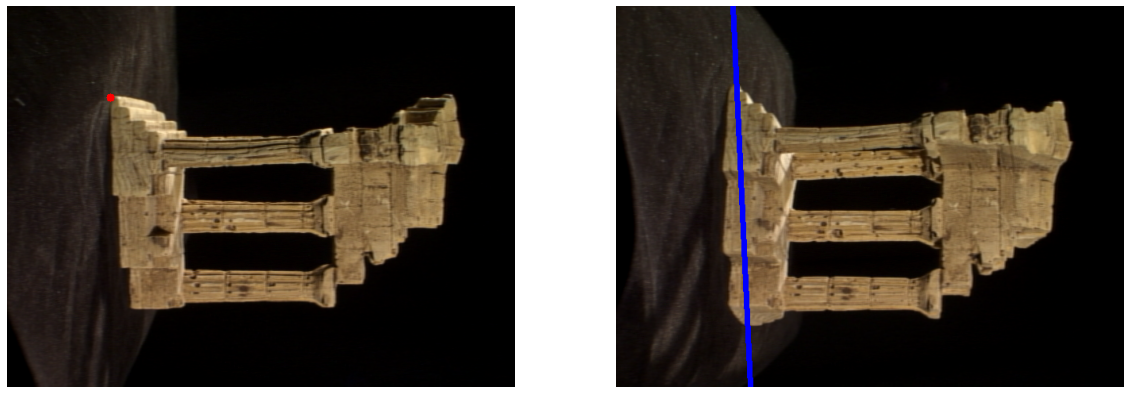

In [3]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1,2, figsize = (20,20))
axis[0].imshow(cv.cvtColor(im1, cv.COLOR_BGR2RGB))
axis[0].axis('off')
axis[1].imshow(cv.cvtColor(im2, cv.COLOR_BGR2RGB))
axis[1].axis('off')
plt.show()

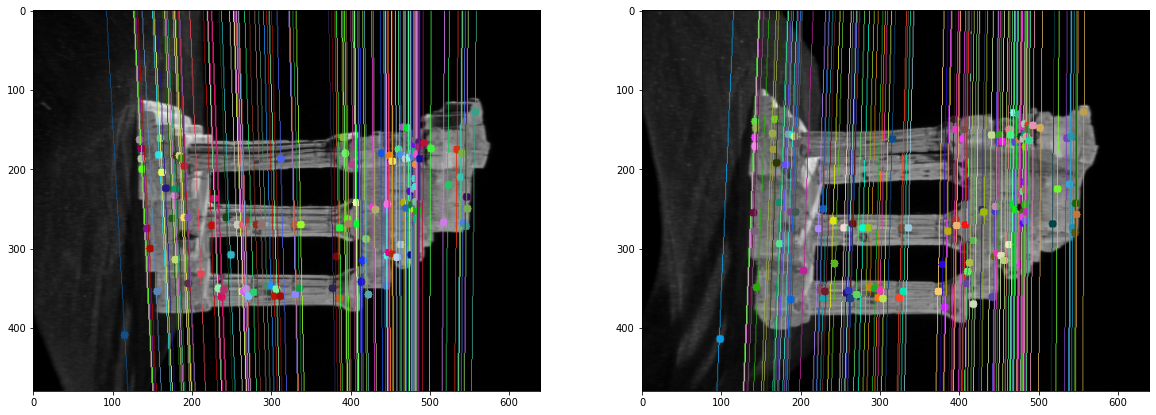

In [9]:
img1 = cv.imread(r'./templeSparseRing/' + im1_fn, 0)
img2 = cv.imread(r'./templeSparseRing/' + im2_fn, 0) 
sift = cv.SIFT_create()

keypoint1, descriptor1 = sift.detectAndCompute(img1, None)
keypoint2, descriptor2 = sift.detectAndCompute(img2, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptor1, descriptor2, k=2)
points1 = []
points2 = []

for i,(a,b) in enumerate(matches):
    if a.distance < 0.8 * b.distance:
        points2.append(keypoint2[a.trainIdx].pt)
        points1.append(keypoint1[a.queryIdx].pt)

points1 = np.int32(points1)
points2 = np.int32(points2)
F, mask = cv.findFundamentalMat(points1, points2, cv.FM_LMEDS)

points1 = points1[mask.ravel() == 1]
points2 = points2[mask.ravel() == 1]

def drawlines(img1, img2, lines, points1, points2):
    rows, cols = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for rows, pts1, pts2 in zip(lines, points1, points2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0,y0 = map(int, [0, -rows[2]/rows[1] ])
        x1,y1 = map(int, [cols, -(rows[2]+rows[0]*cols)/rows[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv.circle(img1, tuple(pts1), 5, color, -1)
        img2 = cv.circle(img2, tuple(pts2), 5, color, -1)
    return img1,img2

lines1 = cv.computeCorrespondEpilines(points2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, points1, points2)

lines2 = cv.computeCorrespondEpilines(points1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, points2, points1)

plt.figure(figsize = (20, 20))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()